In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Probit
import warnings
warnings.filterwarnings("ignore")
import time

In [ ]:
lcd = pd.read_stata('lendingclub.dta')

In [487]:
def del_dup_col(df, p):
    
    # 모든 행이 0인 열과 모든 행의 일치율이 p이상인 열(중복 열) 제거
    
    # 모든 행이 0인 열 제거(62개의 열)
    del_list = []
    for i in range(df.shape[1]):
        if df.iloc[:,i].mean() == 0:
            del_list.append(i)
    result_df = df.drop(df.columns[del_list], axis='columns')
    
    # 모든 행의 일치율이 p이상인 열(중복 열) 제거(62개의 열)
    # p = 0.1인 경우 206개의 열 제거
    del_list = []
    for i in range(result_df.shape[1]):
        for j in range(i+1, result_df.shape[1]):
            if (result_df.iloc[:,i] == result_df.iloc[:,j]).value_counts(normalize=True)[False] < p:
                del_list.append(i)
    del_list = list(set(del_list))
    result_df2 = result_df.drop(result_df.columns[del_list], axis='columns')
    
    return result_df2

def corr_col_list(df, n):
    
    # 주어진 'depvar'에 대한 correlation 벡터를 절댓값 크기가 큰 순서대로 n개의 행 정렬
    
    abs_desc_cor = sorted(df, key=abs, reverse=True)
    
    col_list = ['depvar']
    for i in range(1, n):
        col_list.append(cor_dep[cor_dep == abs_desc_cor[i]].index.values[0])

    return col_list

def acc_rate(real_m, pred_m, p):
    
    # 예측 모형인 pred_m의 값이 p이상일 때 1, p이하일 때 0으로 반환한 set과 실제 test set인 real_m의 값의 일치율(accuracy)
    # p = thresholds

    check = [1 if j > p else 0 for j in pred_m]
    ac_score = accuracy_score(real_m, check)
    
    return ac_score

def max_acc_rate(real_m, pred_m):
    
    # thresolds인 p의 값을 0부터 1까지 4등분하여 각각의 값에 대하여 accuracy를 계산
    # 다시 주어진 값이 포함된 구간을 4등분하여 각각의 값에 대하여 accuracy를 계산하고 accuracy가 최댓값을 갖도록 rep_num 번 반복
    # 이 때 가장 큰 accuracy 값과 그 때의 thresholds인 p 값을 반환
    
    max = 0
    max_thre = 0
    a = 0
    b = 1
    rep_num = 10
    
    for i in range(rep_num):
        for i in np.linspace(a, b, 5):
            if acc_rate(real_m, pred_m, i) > max:
                max = acc_rate(real_m, pred_m, i)
                max_thre = i
        if max_thre <= a + (b-a)/4:
            a = a
            b = a + (b-a)/2
        elif max_thre == a + (b-a)/2:
            a = a + (b-a)/4
            b = a + 3*(b-a)/4
        else:
            a = a + (b-a)/2
            b = b
            
    return (max, max_thre)

In [6]:
# 모든 행이 0인 열과 모든 행의 일치율이 0.1 이상인 열(중복 열) 제거 후 65개의 variable을 갖는 데이터 셋을 얻음
# 65개의 variable을 갖는 데이터 셋의 correlation 행렬을 구함
lcd2 = del_dup_col(lcd, 0.1)
cor_dep = lcd2.corr()['depvar']

In [8]:
# correlation의 값이 큰 순서대로 독립변수를 설정하고 
# 이 때의 각각의 경우에 대한 OLS, Logit, Probit 모형의 accuracy와 소요시간을 구함

max_acc_rate_ols = []
max_acc_rate_logit = []
max_acc_rate_probit = []
req_time = []
for j in range(8):
    for i in range(2, len(cor_dep)):
        start = time.time()
    
        col_list = corr_col_list(cor_dep, i)
        lcd3 = lcd2[col_list]
        predictor = lcd3.depvar
        variables = lcd3.drop('depvar', axis=1)

        x_train, x_test, y_train, y_test = train_test_split(variables, predictor, test_size=0.2)
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        pred_m1 = sm.OLS(y_train, sm.add_constant(x_train)).fit(disp=False).predict(sm.add_constant(x_test))
        pred_m2 = sm.Logit(y_train, sm.add_constant(x_train)).fit(method='bfgs', disp=False).predict(sm.add_constant(x_test))
        pred_m3 = Probit(y_train, sm.add_constant(x_train)).fit(method='bfgs', disp=False).predict(sm.add_constant(x_test))

        max_acc_rate_ols.append(max_acc_rate(y_test, pred_m1))
        max_acc_rate_logit.append(max_acc_rate(y_test, pred_m2))
        max_acc_rate_probit.append(max_acc_rate(y_test, pred_m3))
        req_time.append(time.time() - start)

In [148]:
# 위에서 구한 각 모형에 대한 accuracy와 소요시간에 대한 리스트를 보기 편하게 정제하는 함수들을 정의함.

def max_list(li):
    
    n = 0
    max_list = []
    max_sm_list = []

    for i in range(len(li)):
        if n == 63:
            max_list.append(max_sm_list)
            n = 0            
            max_sm_list=[]
        max_sm_list.append(li[i][0])
        n += 1
        
    max_list.append(max_sm_list)
    
    return max_list

def diff_list(li):

    diff_li = []
    diff_sm_li = []
    
    for i in range(len(li)-1):
        diff_sm_li = []
        for j in range(len(li[i])-1):
            diff_sm_li.append(li[i][j+1] - li[i][j])
        diff_li.append(diff_sm_li)
        
    diff_li.append(diff_sm_li)
        
    return diff_li

def mean_list(li):
    
    sum = np.zeros(len(li[0]))
    
    for i in range(len(li)):
        sum += np.array(li[i])
    
    mean = sum / len(li)
    
    return list(mean)

def absmax_and_index(li):
    abs_desc = sorted(li, reverse=True)
    
    absmax = 0
    index = 0
    absmax_and_index_list = []
    
    for i in range(len(li)):
        absmax = abs_desc[i]
        index = li.index(absmax)
        absmax_and_index_list.append([absmax, index])
    
    return absmax_and_index_list

In [311]:
ols1 = max_list(max_acc_rate_ols)
ols2 = diff_list(ols1)
ols3 = mean_list(ols2)
ols4 = absmax_and_index(ols3)

logit1 = max_list(max_acc_rate_logit)
logit2 = diff_list(logit1)
logit3 = mean_list(logit2)
logit4 = absmax_and_index(logit3)

probit1 = max_list(max_acc_rate_probit)
probit2 = diff_list(probit1)
probit3 = mean_list(probit2)
probit4 = absmax_and_index(probit3)

ols5 = []
logit5 = []
probit5 = []

for i in range(len(max_acc_rate_ols[:len(cor_dep)-2])):
    ols5.append(max_acc_rate_ols[:len(cor_dep)-2][i][0])
    logit5.append(max_acc_rate_logit[:len(cor_dep)-2][i][0])
    probit5.append(max_acc_rate_probit[:len(cor_dep)-2][i][0])

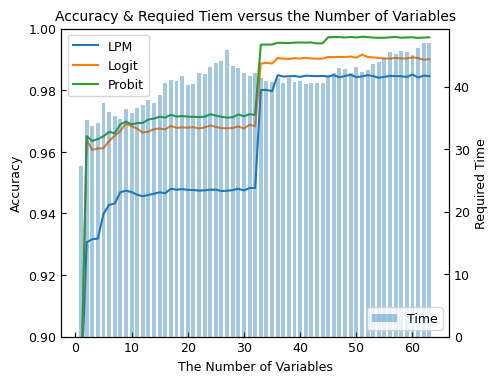

In [492]:
# variable의 개수에 따른 각 모형(OLS, Logit, Probit)의 accuracy와 소요 시간에 대한 그래프

plt.rcParams['font.size'] = 9

x_dep_num = np.arange(1, len(cor_dep)-1)
y_ols1 = np.array(ols5)
y_logit1 = np.array(logit5)
y_probit1 = np.array(probit5)
t = np.array(req_time[:len(cor_dep)-2])

fig, ax1 = plt.subplots(figsize=(5,4))
ax1.plot(x_dep_num, y_ols1, label='LPM')
ax1.plot(x_dep_num, y_logit1, label='Logit')
ax1.plot(x_dep_num, y_probit1, label='Probit')
ax1.set_ylim(0.9, 1)
ax1.set_xlabel('The Number of Variables')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='both', direction='in')

ax2 = ax1.twinx()
ax2.bar(x_dep_num, t, label='Time', alpha=0.4, width=0.7)
ax2.set_ylabel('Required Time')
ax2.tick_params(axis='y', direction='in')

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.title('Accuracy & Requied Tiem versus the Number of Variables', size = 10)

plt.show()

In [248]:
# accuracy를 가장 많이 높히는 variable을 7개를 순서대로 구함

var_list_num = []
for i in range(1, 6):
    var_list_num.append(ols4[i][1]+2)
    var_list_num.append(logit4[i][1]+2)
    var_list_num.append(probit4[i][1]+2)
var_list_num = list(set(var_list_num))
var_list_num

[33, 36, 5, 6, 8, 9, 45]

In [208]:
# 위에서 구한 variable을 하나씩 추가하여 각 경우에 대한 accuracy를 계산함

col_name_list = ['depvar']
ols_pred = []
logit_pred = []
probit_pred = []
for i in var_list_num:
    col_name_list.append(col_list[i])
    lcd3 = lcd2[col_name_list]
    
    predictor = lcd3.depvar
    variables = lcd3.drop('depvar', axis=1)

    x_train, x_test, y_train, y_test = train_test_split(variables, predictor)

    result1 = sm.OLS(y_train, sm.add_constant(x_train)).fit(disp=False)
    pred_m1 = result1.predict(sm.add_constant(x_test))

    result2 = sm.Logit(y_train, sm.add_constant(x_train)).fit(method='bfgs',disp=False)
    pred_m2 = result2.predict(sm.add_constant(x_test))

    result3 = Probit(y_train, sm.add_constant(x_train)).fit(method='bfgs', disp=False)
    pred_m3 = result3.predict(sm.add_constant(x_test))
    
    ols_pred.append(max_acc_rate(y_test, pred_m1)[0])
    logit_pred.append(max_acc_rate(y_test, pred_m2)[0])
    probit_pred.append(max_acc_rate(y_test, pred_m3)[0])

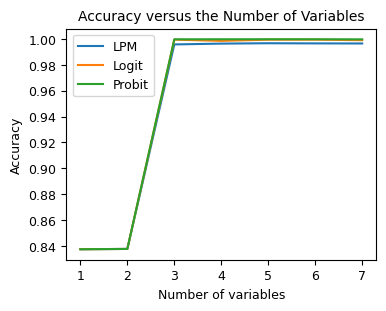

In [491]:
# variable 개수에 따른 accuracy의 그래프

plt.style.use('default')
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 9

x_pred = np.arange(1, len(var_list_num)+1)
y_ols2 = ols_pred
y_logit2 = logit_pred
y_probit2 = probit_pred

fig = plt.figure()
fig.set_facecolor('white')
ax3 = fig.add_subplot()
 
ax3.plot(x_pred, y_ols2, label='LPM') 
ax3.plot(x_pred, y_logit2, label='Logit') 
ax3.plot(x_pred, y_probit2, label='Probit') 
 
ax3.set_xlabel('Number of variables')
ax3.set_ylabel('Accuracy')
plt.title('Accuracy versus the Number of Variables', size = 10)
ax3.legend()
plt.show()

In [489]:
# 위에서 구한 variable 중 3개를 선택하여 각각 OLS, Logit, Probit 모형에 적용함

op_col_list = ['depvar', 'installment', 'funded_amnt_inv', 'total_rec_prncp']
lcd4 = lcd2[op_col_list]

predictor = lcd4.depvar
variables = lcd4.drop('depvar', axis=1)
x_train, x_test, y_train, y_test = train_test_split(variables, predictor)

In [497]:
result1 = sm.OLS(y_train, sm.add_constant(x_train)).fit(disp=False)
pred_m1 = result1.predict(sm.add_constant(x_test))
print("thresholds : %0.6f 일때 accuracy : %0.6f 로 최대값을 가짐" 
      % (max_acc_rate(y_test, pred_m1)[1], max_acc_rate(y_test, pred_m1)[0]))
result1.summary()

thresholds : 0.152466 일때 accuracy : 0.996977 로 최대값을 가짐


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 depvar   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 4.261e+05
Date:                Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:46:44   Log-Likelihood:                 41112.
No. Observations:              819689   AIC:                        -8.222e+04
Df Residuals:                  819685   BIC:                        -8.217e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1584      0.000    325.241      0.000       0.157       0.159
installment      9.724e-05   3.95e-06     24.620      0.000    8.95e-05       0.000
funded_amnt_inv  5.933e-05   1.35e-07    439.698      0.000    5.91e-05    5.96e-05
total_rec_prncp  -6.94e-05   6.14e-08  -1129.990      0.000   -6.95e-05   -6.93e-05
==============================================================================
Omnibus:                   268371.385   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1294176.298
Skew:                           1.524   Prob(JB):                         0.00
Kurtosis:                       8.349   Cond. No.                     4.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [498]:
result2 = sm.Logit(y_train, sm.add_constant(x_train)).fit(disp=False)
pred_m2 = result2.predict(sm.add_constant(x_test))
print("thresholds : %0.6f 일때 accuracy : %0.6f 로 최대값을 가짐" 
      % (max_acc_rate(y_test, pred_m2)[1], max_acc_rate(y_test, pred_m2)[0]))
result2.summary()

thresholds : 0.250000 일때 accuracy : 0.999945 로 최대값을 가짐


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 depvar   No. Observations:               819689
Model:                          Logit   Df Residuals:                   819685
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Jan 2021   Pseudo R-squ.:                  0.9985
Time:                        22:46:57   Log-Likelihood:                -526.20
converged:                       True   LL-Null:                   -3.6270e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.9077      0.254    -35.096      0.000      -9.405      -8.410
installment         0.0064      0.004      1.729      0.084      -0.001       0.014
funded_amnt_inv     1.0619      0.100     10.605      0.000       0.866       1.258
total_rec_prncp    -1.0622      0.100    -10.606      0.000      -1.258      -0.866
===================================================================================

Possibly complete quasi-separation: A fraction 0.76 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [499]:
result3 = Probit(y_train, sm.add_constant(x_train)).fit(method='bfgs', disp=False)
pred_m3 = result3.predict(sm.add_constant(x_test))
print("thresholds : %0.6f 일때 accuracy : %0.6f 로 최대값을 가짐" 
      % (max_acc_rate(y_test, pred_m3)[1], max_acc_rate(y_test, pred_m3)[0]))
result3.summary()

thresholds : 0.007812 일때 accuracy : 0.999876 로 최대값을 가짐


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                 depvar   No. Observations:               819689
Model:                         Probit   Df Residuals:                   819685
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Jan 2021   Pseudo R-squ.:                  0.9950
Time:                        22:47:14   Log-Likelihood:                -1797.2
converged:                      False   LL-Null:                   -3.6270e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.4368      0.032    -76.299      0.000      -2.499      -2.374
installment        -0.0067      0.001    -10.942      0.000      -0.008      -0.006
funded_amnt_inv     0.0168      0.000     62.418      0.000       0.016       0.017
total_rec_prncp    -0.0167      0.000    -62.899      0.000      -0.017      -0.016
===================================================================================

Possibly complete quasi-separation: A fraction 0.64 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [253]:
# ROC 커브에서 AUC를 최대로 하는 fpr, tpr, thresholds를 구하는 함수
def max_ftt(fpr, tpr, thresholds):
    max = 0
    thre_index = 0
    for i in range(fpr.shape[0]):
        if max < (1-fpr[i])*tpr[i]:
            max = (1-fpr[i])*tpr[i]
            thre_index = i
            
    return fpr[thre_index], tpr[thre_index], thresholds[thre_index]

LPM 모형의 AUC 최댓값 : 0.996372, 이 때의 thresolds : 0.15213, Accuracy : 0.996959
Logit 모형의 AUC 최댓값 : 0.999933, 이 때의 thresolds : 0.00050, Accuracy : 0.999960
Probit 모형의 AUC 최댓값 : 0.999933, 이 때의 thresolds : 0.00815, Accuracy : 0.999872


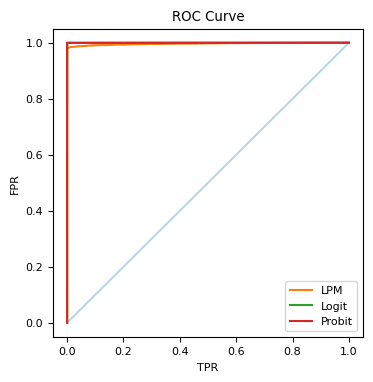

In [501]:
# 각 모형(OLS, Logit, Probit)에 대한 ROC Curve와 각각의 AUC

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['font.size'] = 8

fpr1, tpr1, thresholds1 = roc_curve(y_test, pred_m1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, pred_m2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, pred_m3)
plt.plot([0,1], [0,1], alpha=0.3)
plt.plot(fpr1, tpr1, label='LPM')
plt.plot(fpr2, tpr2, label='Logit')
plt.plot(fpr3, tpr3, label='Probit')
print("LPM 모형의 AUC 최댓값 : %0.6f, 이 때의 thresolds : %0.5f, Accuracy : %0.6f" 
      % (roc_auc_score(y_test, pred_m1), max_ftt(fpr1, tpr1, thresholds1)[2], acc_rate(y_test, pred_m1, max_ftt(fpr1, tpr1, thresholds1)[2])))
print("Logit 모형의 AUC 최댓값 : %0.6f, 이 때의 thresolds : %0.5f, Accuracy : %0.6f" 
      % (roc_auc_score(y_test, pred_m2), max_ftt(fpr2, tpr2, thresholds2)[2], acc_rate(y_test, pred_m2, max_ftt(fpr2, tpr2, thresholds2)[2])))
print("Probit 모형의 AUC 최댓값 : %0.6f, 이 때의 thresolds : %0.5f, Accuracy : %0.6f" 
      % (roc_auc_score(y_test, pred_m2), max_ftt(fpr3, tpr3, thresholds3)[2], acc_rate(y_test, pred_m3, max_ftt(fpr3, tpr3, thresholds3)[2])))

plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('ROC Curve')
plt.legend()

plt.show()

# Result

### Logit 모형 선택
### Variables은 'installment', 'funded_amnt_inv', 'total_rec_prncp'
### Threshold = 0.0005, 이 때의 Accuracy = 0.999960, AUC = 0.999933

## $Pr[y_{}=1|x] = \frac{exp(-8.907683+0.006370x_{installment}+1.061942x_{funded\_amnt\_inv}-1.062195x_{total\_rec\_prncp})}{1+exp(-8.907683+0.006370x_{installment}+1.061942x_{funded\_amnt\_inv}-1.062195x_{total\_rec\_prncp})} \geq 0.0005$

In [511]:
result2.params

const             -8.907683
installment        0.006370
funded_amnt_inv    1.061942
total_rec_prncp   -1.062195
dtype: float64

In [259]:
# predictor2 = lcd.depvar
# variables2 = lcd.drop('depvar', axis=1)

# x_train2, x_test2, y_train2, y_test2 = train_test_split(variables2, predictor2)
# scaler2 = StandardScaler()
# x_train2 = scaler2.fit_transform(x_train2)
# x_test2 = scaler2.transform(x_test2)

In [260]:
# result4 = sm.OLS(y_train2, sm.add_constant(x_train2)).fit()
# result5 = sm.Logit(y_train2, sm.add_constant(x_train2)).fit(method='lbfgs')
# result6 = Probit(y_train2, sm.add_constant(x_train2)).fit(method='lbfgs')

In [261]:
# pred_m4 = result4.predict(sm.add_constant(x_test2, has_constant='add'))
# pred_m5 = result5.predict(sm.add_constant(x_test2, has_constant='add'))
# pred_m6 = result6.predict(sm.add_constant(x_test2, has_constant='add'))

In [262]:
# print(max_acc_rate(y_test2, pred_m4))
# print(max_acc_rate(y_test2, pred_m5))
# print(max_acc_rate(y_test2, pred_m6))

(0.9841854847564323, 0.31)
(0.9983237565421074, 0.34)
(0.9984701533506569, 0.37)


In [504]:
del_list = []
for i in range(lcd.shape[1]):
    if lcd.iloc[:,i].mean() == 0:
        del_list.append(i)
del_list

In [506]:
print(del_list)

[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]


In [ ]:
result_df = lcd.drop(lcd.columns[del_list], axis='columns')

In [510]:
lcd4[:30]

,depvar,installment,funded_amnt_inv,total_rec_prncp
0,0.0,605.62,19000.0,19000.00
1,0.0,312.86,10000.0,10000.00
2,0.0,197.78,6000.0,6000.00
3,1.0,836.89,25200.0,12882.27
4,0.0,269.52,8000.0,8000.00
5,1.0,637.49,20000.0,5541.33
6,0.0,1126.29,36000.0,36000.00
7,0.0,265.68,8000.0,8000.00
8,1.0,756.84,22000.0,8031.97
9,0.0,843.22,28000.0,28000.00
